### **Mounting From Drive**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Importing Libraries**

In [1]:
!pip install fuzzywuzzy

In [2]:
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

from gensim.models import KeyedVectors
from fuzzywuzzy import process

from imblearn.under_sampling import RandomUnderSampler

/usr/local/lib/python3.11/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [4]:
import gensim.downloader as api
path = api.load("word2vec-google-news-300", return_path=True)
print(path)

[==================================================] 100.0% 1662.8/1662.8MB downloaded
/root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


### **Reading The csv Files**

In [7]:
path_train = "/content/drive/MyDrive/Colab Notebooks/SentimentalAnalysis/train_data.csv"
path_brand = "/content/drive/MyDrive/Colab Notebooks/SentimentalAnalysis/title_brand.csv"
df = pd.read_csv(path_train)
df_brand = pd.read_csv(path_brand)

<ipython-input-7-016e3278c66f>:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_train)


### **Data Understanding**

In [8]:
pd.set_option('display.max_rows', None)  # To display all rows
pd.set_option('display.max_columns', None)  # To display all columns

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838944 entries, 0 to 838943
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   overall         838944 non-null  int64 
 1   vote            191468 non-null  object
 2   verified        838944 non-null  bool  
 3   reviewTime      838944 non-null  object
 4   reviewerID      838944 non-null  object
 5   asin            838944 non-null  object
 6   style           490613 non-null  object
 7   reviewerName    838717 non-null  object
 8   reviewText      838944 non-null  object
 9   summary         838868 non-null  object
 10  unixReviewTime  838944 non-null  int64 
dtypes: bool(1), int64(2), object(8)
memory usage: 64.8+ MB


In [10]:
df['verified'].value_counts()

verified
True     720389
False    118555
Name: count, dtype: int64

In [11]:
df = df[df['verified'] == True]

In [12]:
df.head(20)

overall vote  verified  reviewTime      reviewerID        asin  \
1         5  NaN      True  2016-06-06  A2NETQRG6JHIG7  0511189877   
2         4  NaN      True  2016-03-10  A12JHGROAX49G7  0511189877   
3         5  NaN      True  2016-01-14  A1KV65E2TMMG6F  0511189877   
4         5  NaN      True  2016-10-20  A280POPEWI0NSA  0594459451   
5         5  NaN      True  2016-06-18  A2KTAT1Y3VRVSJ  0594459451   
6         5  NaN      True  2016-02-11  A1CHTT6E3NV5YL  0594459451   
7         2  NaN      True  2016-04-02  A1TI6WQ69ST707  0594481902   
8         4  NaN      True  2016-01-10  A38NYFVE0FCZRG  0594481902   
9         5  NaN      True  2016-09-19  A2LLAAYS88V96P  0594296420   
10        5  NaN      True  2016-09-03  A1CGJVDE638R1C  0594296420   
11        3  NaN      True  2016-03-30  A3V4DTR6Z66SF2  0594296420   
12        5  NaN      True  2016-02-10   A11NQRQHMYW5N  0594296420   
13        5  NaN      True  2016-09-15  A3P57SQBZAEZFG  059449771X   
14        3  NaN      True  2016-08-31  A3A84C8X530RHK  059449771X   
15        5  NaN      True  2016-05-18   APIQOJU6IIIQG  059449771X   
16        5  NaN      True  2017-01-10  A3472NC8JOKIW1  0594450268   
17        5  NaN      True  2017-06-29  A2IC3RIPB6HKSQ  073530498X   
18        5  4.0      True  2017-02-18  A1JHNR71TPEETW  073530498X   
19        5  2.0      True  2016-12-26   AU7SO8B4M5UBA  073530498X   
20        5  NaN      True  2016-10-22  A1JXLTQ5VWPGGV  0764207474   

                             style         reviewerName  \
1                              NaN         Qrysta White   
2                              NaN              Linwood   
3                              NaN        Dane Williams   
4                              NaN          Kristina H.   
5                              NaN              MnMMom3   
6                              NaN       Amazon Shopper   
7                              NaN                 kyle   
8                              NaN            S. Artist   
9                              NaN              Tabatha   
10                             NaN      Estabot MK.3000   
11                             NaN              Bradley   
12                             NaN                 BenE   
13                             NaN             F Kukura   
14                             NaN         Dana Serrano   
15                             NaN              sharont   
16                             NaN                Joyce   
17    {'Format:': ' Spiral-bound'}  Aine O&#039;brocken   
18    {'Format:': ' Spiral-bound'}      Amazon Customer   
19    {'Format:': ' Spiral-bound'}                 ruth   
20  {'Format:': ' Kindle Edition'}      chb book addict   

                                           reviewText  \
1   First time I've EVER had a remote that needed ...   
2   Got them and only 2 of them worked. company ca...   
3   I got tired of the remote being on the wrong s...   
4   After purchasing cheap cords from another webs...   
5   This is a great charging cable for the Nook.  ...   
6   The 90 degree connector is a bonus that allows...   
7   I bought this thinking it would be a great rep...   
8   It works!  I was skeptical about ordering it b...   
9   Brand name adapter this is just like the one y...   
10  I would like to say this product works just fi...   
11  Purchased for my mother since she lost her ori...   
12  I used this to replace the charger my Nook HD+...   
13  I have a Nook HD+.  As they are no longer prod...   
14  Since we still have original Nooks we thought ...   
15  I was skeptical of ordering these chargers as ...   
16  Fits a Nook HD+ perfectly and gave this tablet...   
17  Ended up using this as a birthday gift for one...   
18  I bought this to display some vintage photos t...   
19  Cute! Bought 2 for my daughter. I thought it w...   
20  This was a well developed story with character...   

                                              summary  unixReviewTime  
1                 zero 

In [13]:
df_brand.head(20)

asin                                              title  \
0   0011300000  Genuine Geovision 1 Channel 3rd Party NVR IP S...   
1   0043396828  Books "Handbook of Astronomical Image Processi...   
2   0060009810                                     One Hot Summer   
3   0060219602  Hurray for Hattie Rabbit: Story and pictures (...   
4   0060786817                     sex.lies.murder.fame.: A Novel   
5   0070524076                                    College Physics   
6   0091912407  Girl with a One-track Mind: Confessions of the...   
7   0101635370  abcGoodefg&reg; 4GB USB 2.0 Mp3 Music Player w...   
8   0132492776  Wireless Bluetooth Headphones Earbuds with Mic...   
9   0132793040  Kelby Training DVD: Mastering Blend Modes in A...   
10  0151004714                             The Last Life: A Novel   
11  0151014841                                       Lady Lazarus   
12  0205291252          Practical Modern Basketball (3rd Edition)   
13  0246003235  SAMSUNG Evo Plus 64 GB MicroSDXC Class 10 80 M...   
14  0285175270  BOOX Max Carta Ereader,13.3" Flexible Screen 1...   
15  0303532572  TDK Hi8 MP120 Premium Performance Camcorder Vi...   
16  0302643370  The Lord of the Rings: Return of the King - Ex...   
17  0310810515                        Linen-Look Pattern Black LG   
18  0312171048                  The Angel Doll: A Christmas Story   
19  0312331363                                       Scared Money   

                                           brand  
0                                      GeoVision  
1                                   33 Books Co.  
2   Visit Amazon's Carolina Garcia Aguilera Page  
3            Visit Amazon's Dick Gackenbach Page  
4               Visit Amazon's Lolita Files Page  
5          Visit Amazon's Alan Giambattista Page  
6                                       ABBY LEE  
7                                     Crazy Cart  
8                                Enter The Arena  
9                                 Kelby Training  
10             Visit Amazon's Claire Messud Page  
11    Visit Amazon's Andrew Foster Altschul Page  
12                                John R. Wooden  
13                                       Samsung  
14                                          BOOX  
15                          TDK Electronics Corp  
16                                            WB  
17                 Visit Amazon's Zondervan Page  
18             Visit Amazon's Jerry Bledsoe Page  
19                                    James Hime

<Axes: >

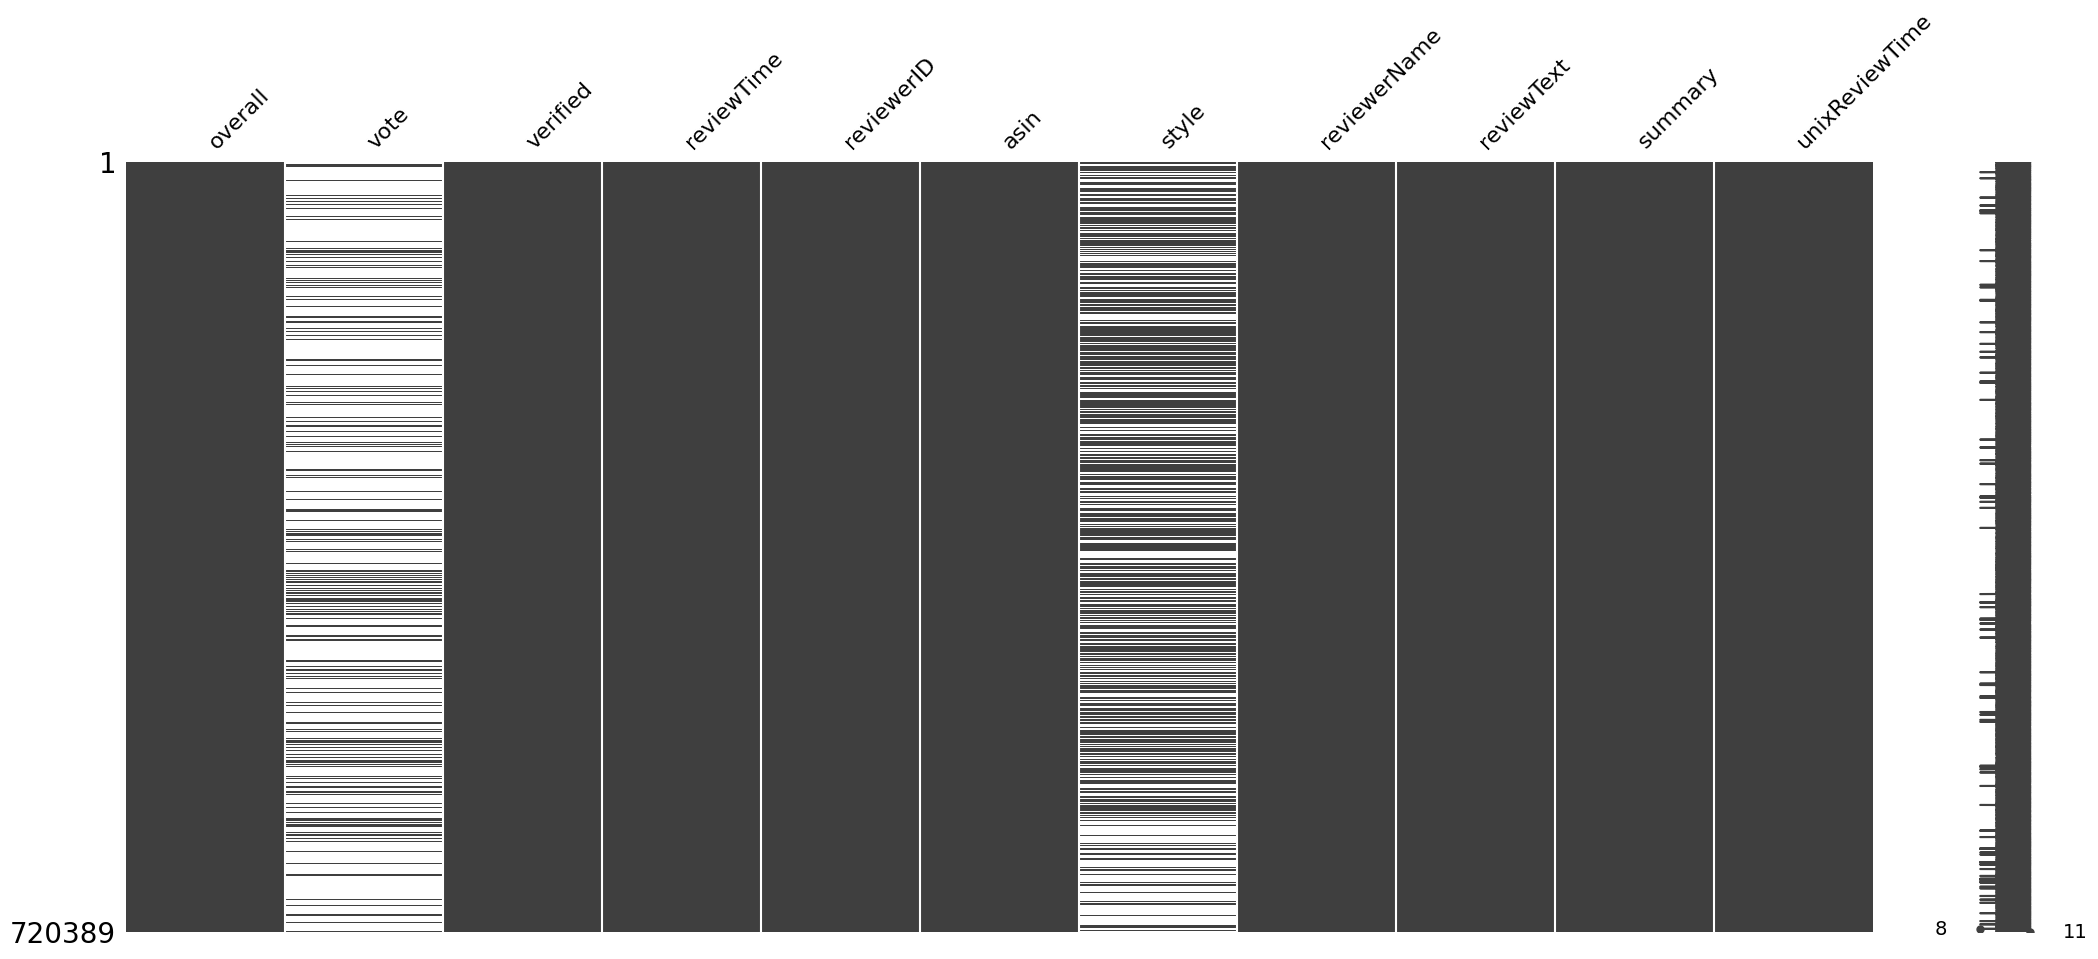

In [14]:
msno.matrix(df)

<Axes: >

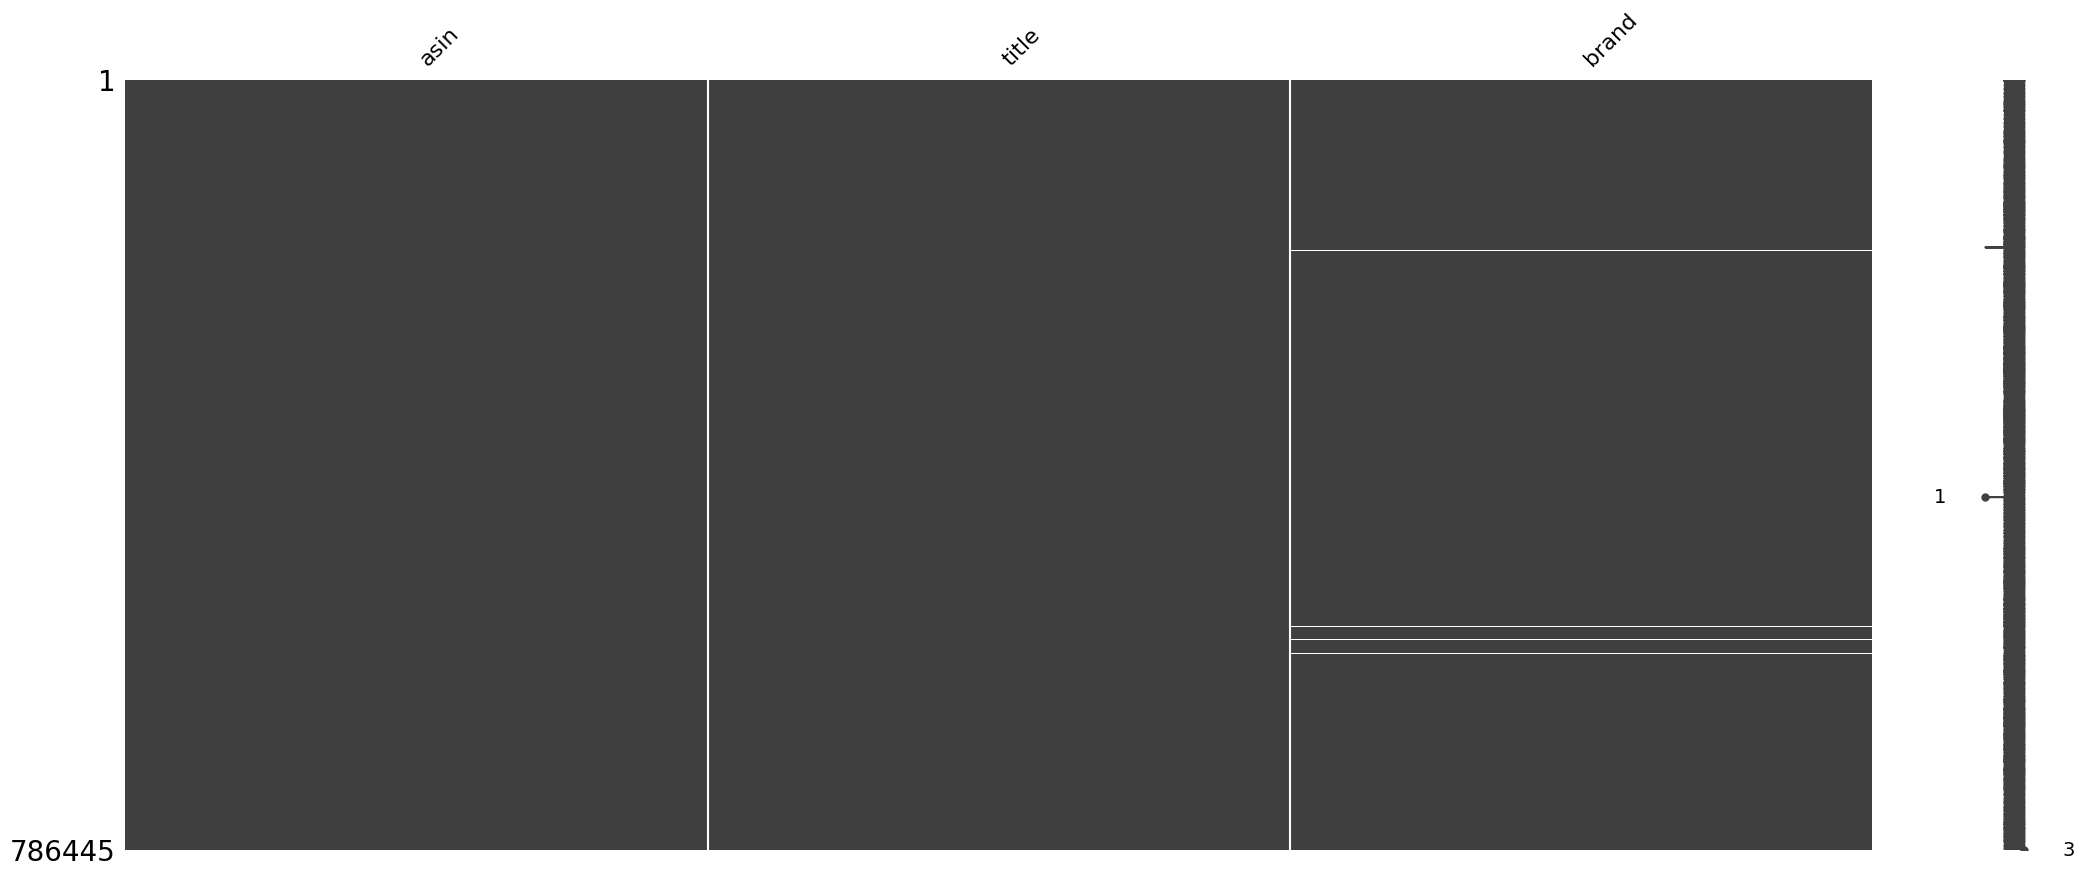

In [15]:
msno.matrix(df_brand)

### **Analysis**

#### **Task 1**

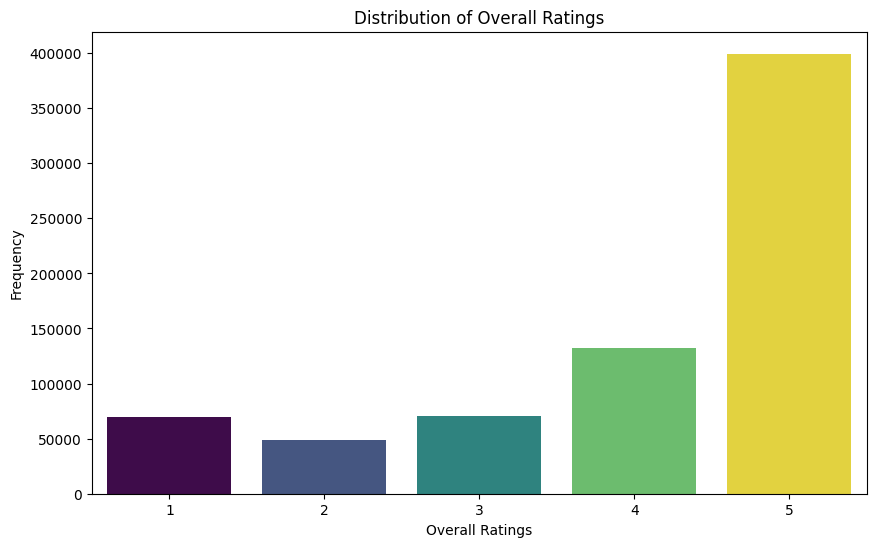

In [16]:
plt.figure(figsize=(10, 6))
sns.countplot(x='overall', data=df, hue='overall', palette='viridis', legend=False)
plt.title('Distribution of Overall Ratings')
plt.xlabel('Overall Ratings')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=[1, 2, 3, 4, 5])
plt.show()

In [17]:
df['overall'].value_counts()

overall
5    399456
4    132652
3     70274
1     69344
2     48663
Name: count, dtype: int64

In [18]:
undersample = RandomUnderSampler()
X = df.drop('overall', axis=1)
y = df['overall']
X_sampled, y_sampled = undersample.fit_resample(X, y)

In [19]:
print(type(y_sampled))

<class 'pandas.core.series.Series'>


In [20]:
y_sampled = pd.DataFrame({'overall': y_sampled})

In [21]:
print(y_sampled.columns)

Index(['overall'], dtype='object')


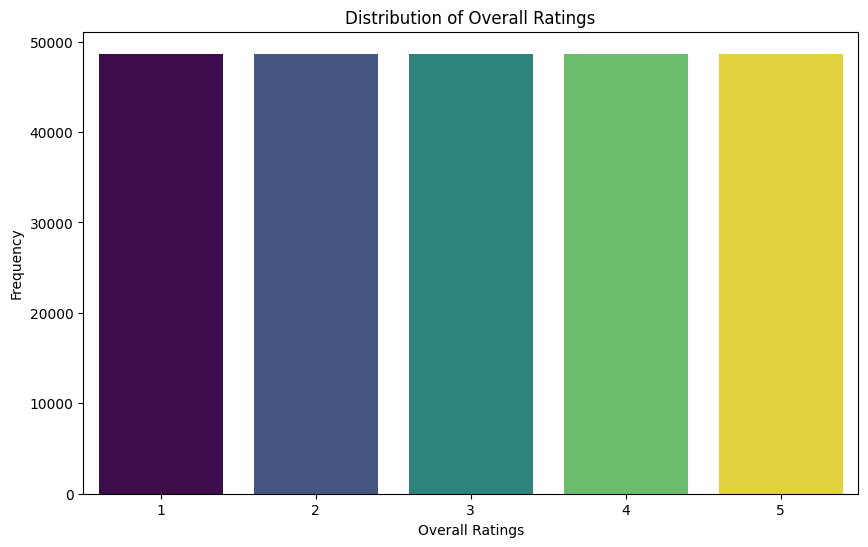

In [22]:
plt.figure(figsize=(10, 6))
sns.countplot(x='overall', data=y_sampled, hue='overall', palette='viridis', legend=False)
plt.title('Distribution of Overall Ratings')
plt.xlabel('Overall Ratings')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=[1, 2, 3, 4, 5])
plt.show()

In [23]:
y_sampled['overall'].value_counts()

overall
1    48663
2    48663
3    48663
4    48663
5    48663
Name: count, dtype: int64

#### **Task 2**

In [55]:
positive_comments = df[df['overall'] >= 4]['reviewText']
neutral_comments = df[df['overall'] == 3]['reviewText']
negative_comments = df[df['overall'] <= 2]['reviewText']

In [56]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [57]:
def generate_wordcloud(comments, title):
    text = ' '.join(comments)
    wordcloud = WordCloud(width=800, height=400,
                          background_color='white',
                          stopwords=stop_words,
                          collocations=False).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

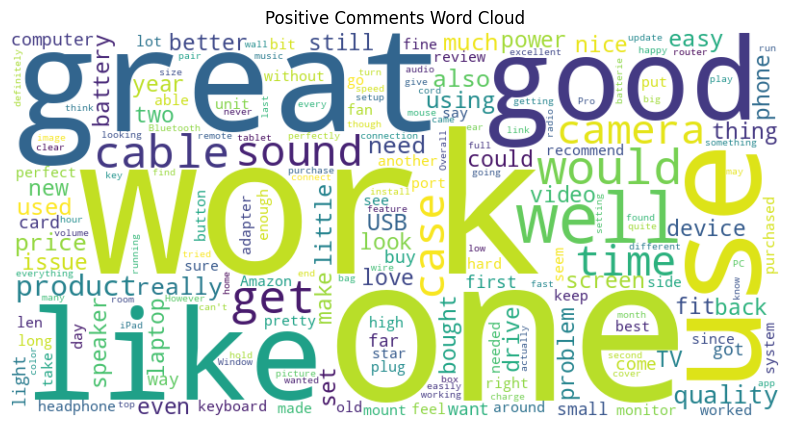

In [58]:
generate_wordcloud(positive_comments, 'Positive Comments Word Cloud')

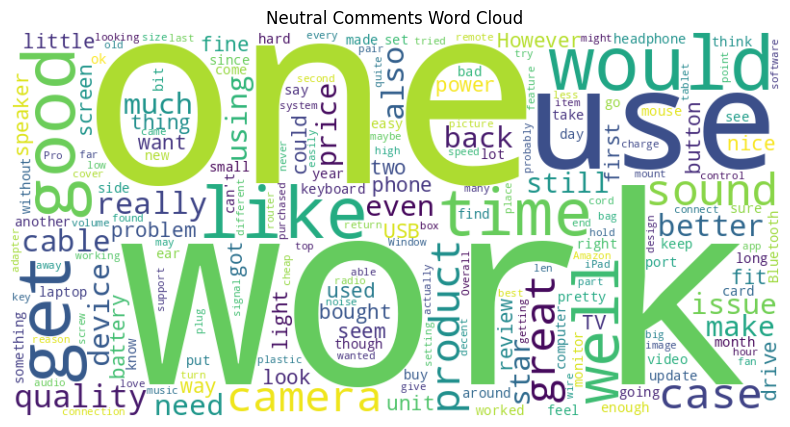

In [59]:
generate_wordcloud(neutral_comments, 'Neutral Comments Word Cloud')

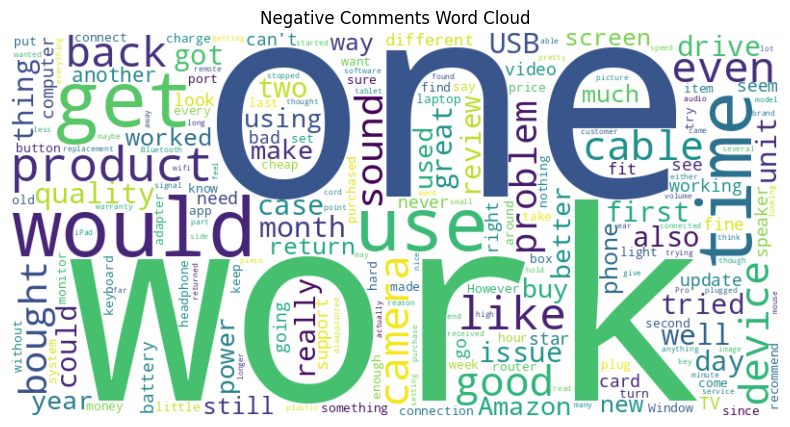

In [60]:
generate_wordcloud(negative_comments, 'Negative Comments Word Cloud')

In [61]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [62]:
more_s_words = ['one', 'work', 'would', 'use', 'get', 'like', 'even']

In [63]:
stop_words.update(more_s_words)

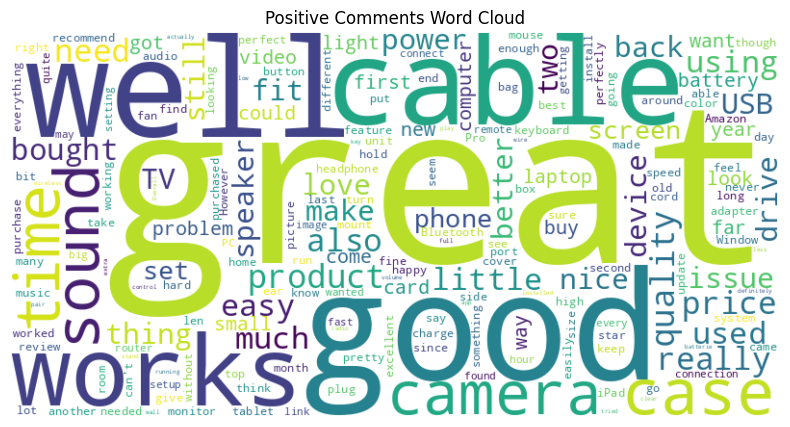

In [64]:
generate_wordcloud(positive_comments, 'Positive Comments Word Cloud')

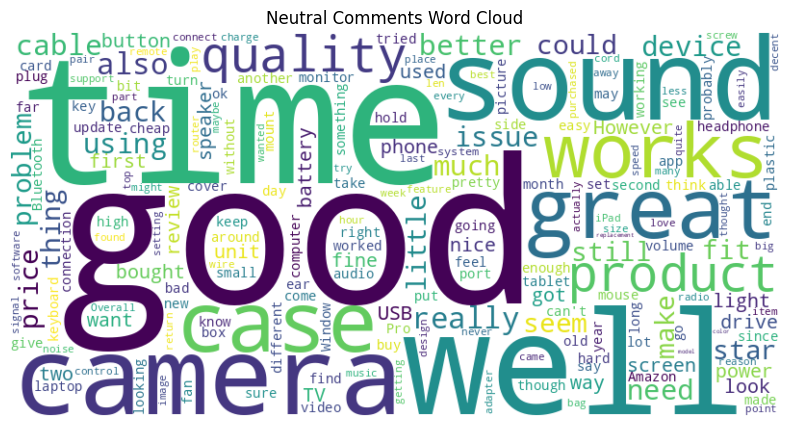

In [65]:
generate_wordcloud(neutral_comments, 'Neutral Comments Word Cloud')

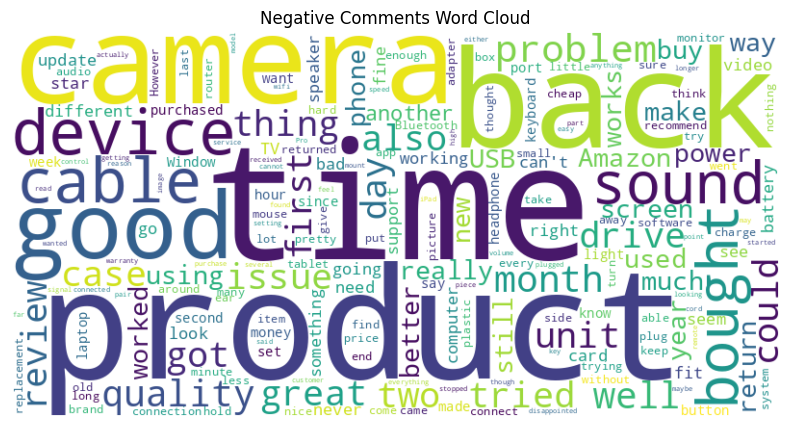

In [66]:
generate_wordcloud(negative_comments, 'Negative Comments Word Cloud')

In [67]:
def filter_adjectives(comments):
    adjectives = []
    for comment in comments:
        words = word_tokenize(comment)
        tagged_words = pos_tag(words)
        adjectives += [word for word, pos in tagged_words if pos in ('JJ', 'JJR', 'JJS') and word.lower() not in stop_words]
    return adjectives

In [68]:
# JJ: This tag represents standard adjectives (e.g., "happy", "quick").
# JJR: This stands for "comparative adjectives," which are used to compare two things (e.g., "happier", "quicker"). It indicates a relative change or comparison.
# JJS: This represents "superlative adjectives," used to describe the highest degree among three or more items (e.g., "happiest", "quickest").

In [69]:
from nltk import pos_tag, word_tokenize
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

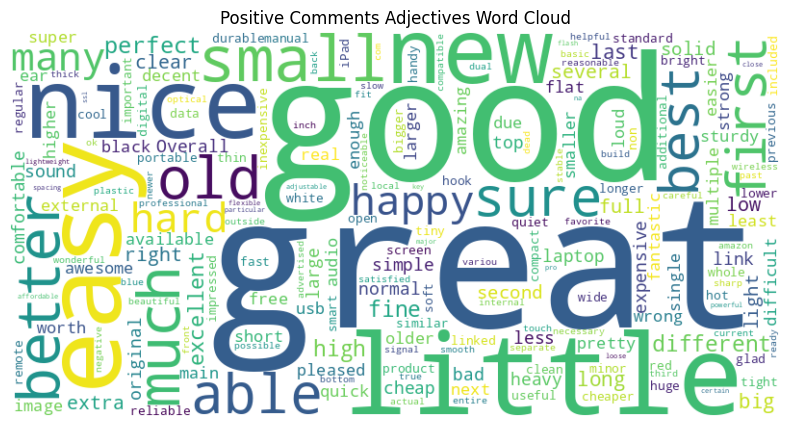

In [70]:
positive_adjective = filter_adjectives(positive_comments)
generate_wordcloud(positive_adjective, 'Positive Comments Adjectives Word Cloud')

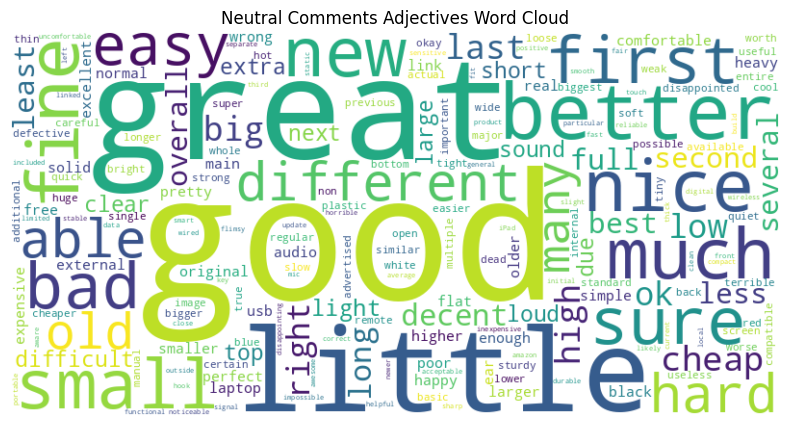

In [71]:
neutral_adjective = filter_adjectives(neutral_comments)
generate_wordcloud(neutral_adjective, 'Neutral Comments Adjectives Word Cloud')

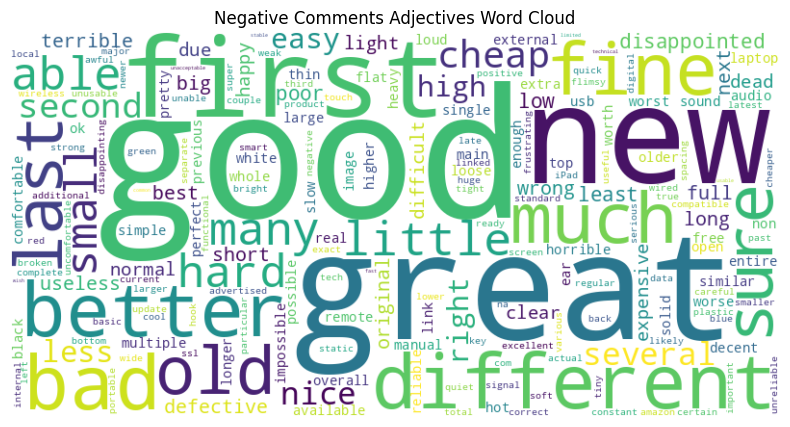

In [72]:
negative_adjective = filter_adjectives(negative_comments)
generate_wordcloud(negative_adjective, 'Negative Comments Adjectives Word Cloud')

In [99]:
more_s_words.extend(['great', 'good', 'new', 'laptop', 'better', 'first', 'much', 'little', 'sure', 'able', 'many', 'hard', 'last', 'second', 'several', 'right', 'old', 'small', 'nice', 'easy', 'different', 'fine'])

In [100]:
stop_words.update(more_s_words)

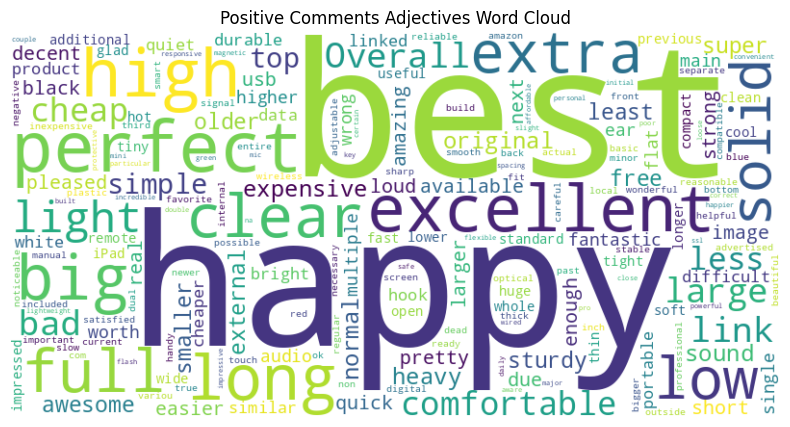

In [101]:
generate_wordcloud(positive_adjective, 'Positive Comments Adjectives Word Cloud')

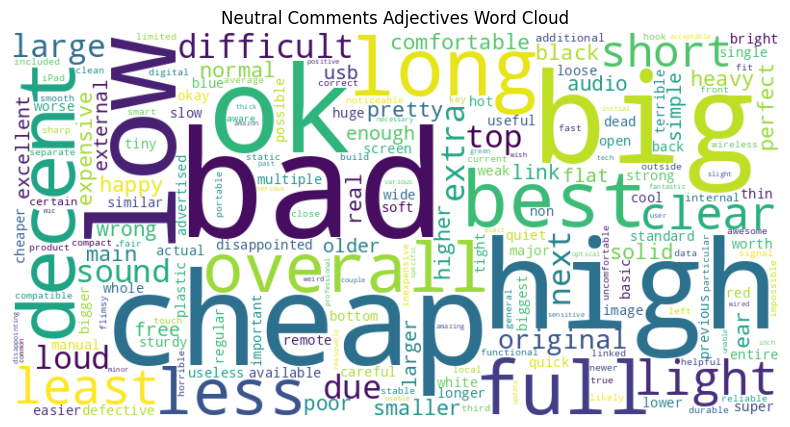

In [105]:
generate_wordcloud(neutral_adjective, 'Neutral Comments Adjectives Word Cloud')

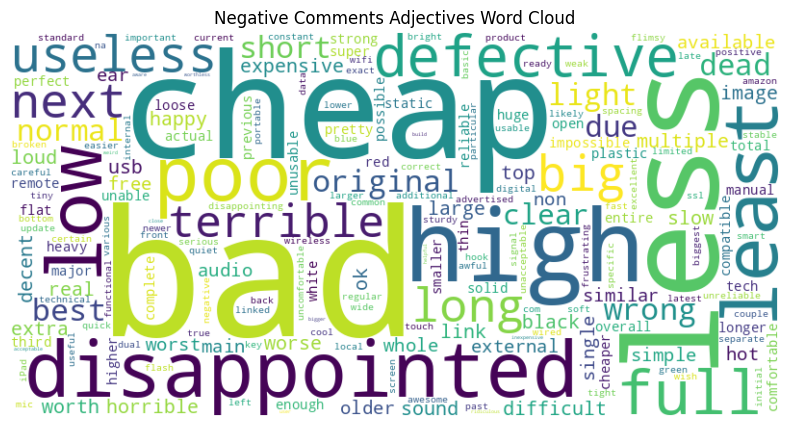

In [103]:
generate_wordcloud(negative_adjective, 'Negative Comments Adjectives Word Cloud')

#### **Task 3**

In [24]:
df['vote'] = df['vote'].fillna(0)
df['vote'] = pd.to_numeric(df['vote'], errors='coerce')
top_voters = df.groupby('reviewerID')['vote'].sum().reset_index()
top_voters = top_voters.sort_values(by='vote', ascending=False)
top_10_voters = top_voters.head(10)

print(top_10_voters)

            reviewerID    vote
91522   A25GROL6KJV3QG  4572.0
242244   A9K7V1MKJ9BOJ  1337.0
299906   AZPCDY9OQ605E  1045.0
96809   A27UX6C43JYPOT   976.0
234405   A5YWF3BZZYR95   937.0
137048  A2Q4FGPUE3B8V7   933.0
40216   A1I7GW7XZNGTF2   918.0
294842   AXDVANLIPLRDL   884.0
148123  A2V7P952VCUC51   836.0
184223  A3BHELYPYKNB5W   833.0


#### **Task 4**

In [25]:
df['text_length'] = df['reviewText'].str.len()

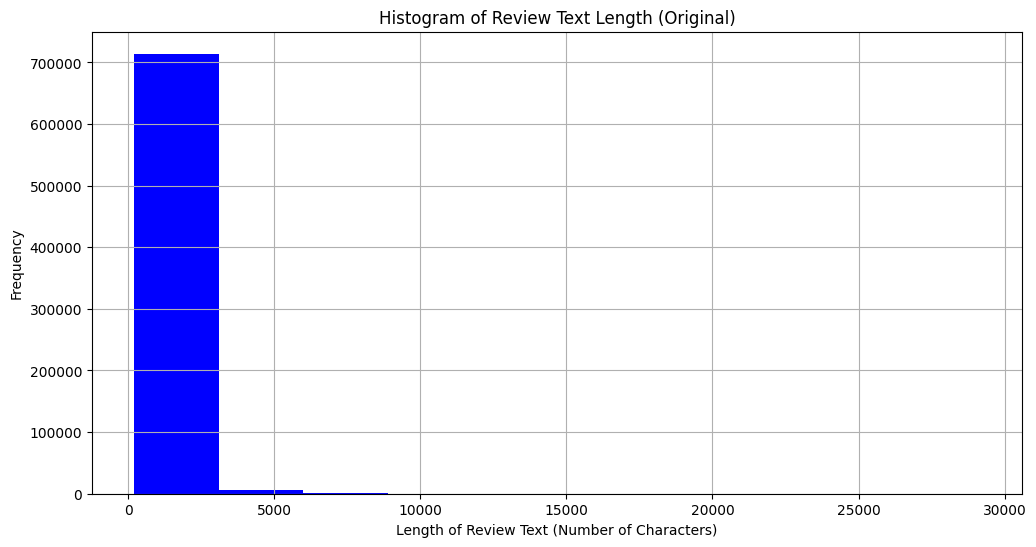

In [26]:
plt.figure(figsize=(12, 6))
plt.hist(df['text_length'], bins=10, color='blue')
plt.title('Histogram of Review Text Length (Original)')
plt.xlabel('Length of Review Text (Number of Characters)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

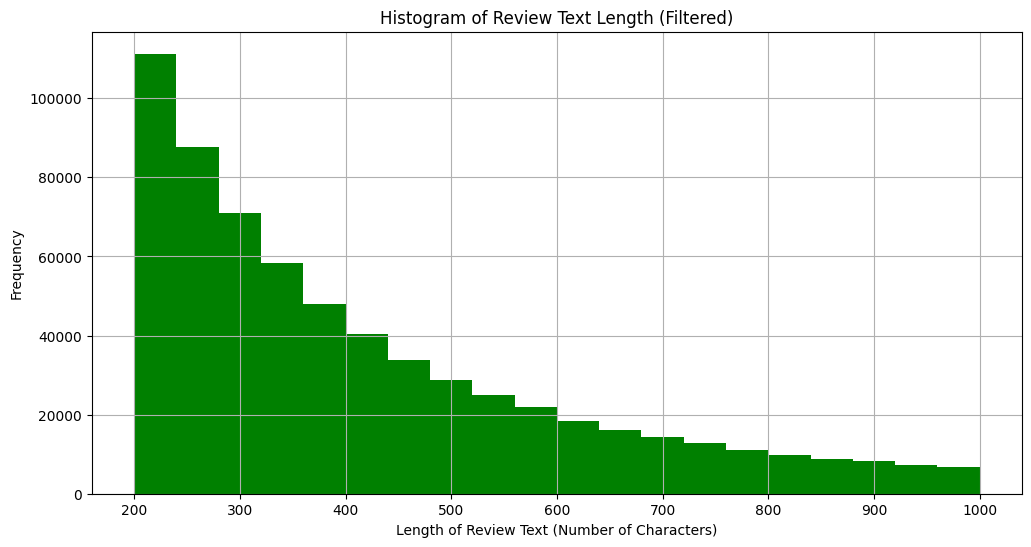

In [27]:
filtered_df = df[(df['text_length'] >= 200) & (df['text_length'] <= 1000)]

plt.figure(figsize=(12, 6))
plt.hist(filtered_df['text_length'], bins=20, color='green')
plt.title('Histogram of Review Text Length (Filtered)')
plt.xlabel('Length of Review Text (Number of Characters)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#### **Task 5**

In [28]:
df[df['style'].notna()]['style'].head(10)

17      {'Format:': ' Spiral-bound'}
18      {'Format:': ' Spiral-bound'}
19      {'Format:': ' Spiral-bound'}
20    {'Format:': ' Kindle Edition'}
38              {'Color:': ' Black'}
39              {'Color:': ' Black'}
41              {'Color:': ' Black'}
42              {'Color:': ' Black'}
44              {'Color:': ' Black'}
45              {'Color:': ' Black'}
Name: style, dtype: object

In [29]:
merged_df = pd.merge(df, df_brand, how='left', on='asin')

In [30]:
five_star_reviews = merged_df[merged_df['overall'] == 5]

top_five_star_products = five_star_reviews.groupby(['brand', 'title']).size().reset_index(name='number_of_5_star_reviews')
top_five_star_products = top_five_star_products.sort_values(by='number_of_5_star_reviews', ascending=False)
top_five_star_products = top_five_star_products[['brand', 'title', 'number_of_5_star_reviews']]
top_10_products = top_five_star_products.head(10)

In [31]:
top_10_products

brand  \
10194  Cambridge Soundworks   
36716               NETGEAR   
52584              StarTech   
45791                  Roku   
47716               Samsung   
31950              Logitech   
4696                   Asus   
59016             VideoSecu   
47713               Samsung   
36673               NETGEAR   

                                                   title  \
10194  OontZ Angle 3 Enhanced Stereo Edition IPX5 Spl...   
36716          NETGEAR N300 WiFi Range Extender (EX2700)   
52584  StarTech USB 2.0 to SATA IDE Adapter (USB2SATA...   
45791  Roku Streaming Stick (3600R) - HD Streaming Pl...   
47716  Samsung 850 EVO 500GB 2.5-Inch SATA III Intern...   
31950  Logitech M570 Wireless Trackball Mouse &ndash;...   
4696   ASUS Tri-Band Gigabit (AC3200) WiFi Router (Up...   
59016  VideoSecu ML531BE TV Wall Mount for Most 27&qu...   
47713  Samsung 850 EVO 250GB 2.5-Inch SATA III Intern...   
36673  NETGEAR 5-Port Gigabit Ethernet Unmanaged Swit...   

       number_of_5_star_reviews  
10194                      1120  
36716                       617  
52584                       566  
45791                       542  
47716                       516  
31950                       511  
4696                        432  
59016                       420  
47713                       420  
36673                       406

#### **Task 6**

In [32]:
brand_stats = merged_df.groupby('brand').agg(
    number_of_reviews=('overall', 'size'),
    average_rating=('overall', 'mean')
).reset_index()

top_brands = brand_stats.sort_values(by='number_of_reviews', ascending=False)
top_10_brands = top_brands.head(10)

In [33]:
top_10_brands[['brand', 'average_rating', 'number_of_reviews']]

brand  average_rating  number_of_reviews
6940       Logitech        3.997765              14765
10036       Samsung        4.038300              12872
768    AmazonBasics        4.186427              11420
1058           Asus        3.900934              10387
10518          Sony        4.013108              10070
862           Anker        4.252065               9081
11085       TP-LINK        3.917305               8622
10041       SanDisk        4.000262               7646
9988        Sabrent        4.006189               6301
7863        NETGEAR        3.839952               5867

### **Satisfaction**

#### **Loading The Model**

In [34]:
model = KeyedVectors.load_word2vec_format('/root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz', binary=True)

#### **Common Typos**

In [35]:
typical_typos = {
    'guarantee': ['guaruntee', 'garantee', 'guarentee'],
    'warranty': ['warrenty', 'warantee', 'warrantee', 'waranty']
}

In [36]:
def find_typos(word, candidates, threshold=80):
    matches = process.extract(word, candidates, limit=10)
    return [match[0] for match in matches if match[1] >= threshold]

#### **Similar Words**

In [42]:
def find_similar_words(word, model, topn=10):
    try:
        similar_words = model.most_similar(word, topn=topn)
        return [word_tuple[0] for word_tuple in similar_words]
    except KeyError:
        return []

In [43]:
keywords = ['guarantee', 'warranty'] + find_typos('guarantee', typical_typos['guarantee']) + find_typos('warranty', typical_typos['warranty'])
for keyword in keywords[:2]:
    keywords += find_similar_words(keyword, model)

In [44]:
keywords = list(set(keywords))

In [45]:
keywords

['guaranteed',
 'guaranteeing',
 'warrenty',
 'guarantees',
 'lifetime_warranty',
 'five-year/###_,###_mile',
 'assurances',
 'insure',
 'garantee',
 'warranties',
 'guarentee',
 'warrantee',
 'assure',
 'Disclaimer_Past_performance',
 'guaruntee',
 'ensure',
 'assurance',
 'Guarantee',
 'warrantees',
 'waranty',
 'Lifetime_Warranty',
 'Warranty',
 'Limited_Warranty',
 'warranty',
 'extended_warranties',
 'guarantee']

#### **Filtering**

In [46]:
keywords_pattern = '|'.join(keywords)
filtered_df = df[df['reviewText'].str.contains(keywords_pattern, case=False, na=False)]

In [47]:
pd.set_option('display.max_colwidth', None)

In [48]:
filtered_df['reviewText'].head(10)

155                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         My Wife & I are in the stage of life where we have dozens of 2-hour VHS format Video Tapes with precious memories of our children.  We have two practically new VCRs which I determined would need a lot of cleaning while transferring the Video to a Digital Format.  Its hard to find good quality Wet Cleaner type VCR cleaners in the stores these days so I was delighted to find your product, a&nbsp;<a data-hook="product-link-linked" class="a-link-normal" href="/Maxell-VP-200-VHS-Wet-Cleaner-2-Pack/dp/B06XR7MXRS/ref=cm_cr_arp_d_rvw_txt?ie=UTF8">Maxell VP-200 VHS Wet Cleaner 2-Pack</a>&nbsp;2-Pack available for a good price.  It will help ensure we obtain High-Quality digital copies of our memories to be able to hand down to our children.
167                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   This adapter works well with my 1994 Corvette. The only issue that I have is the sound quality isn't great. Sometimes I can't hear the vocals of songs playing. It has held up very well with a lot of use though. I have had only one problem using my mp3 player with this adapter, it played the same song over and over again. It was fixed just by simple removing the internal gears and only leaving what was needed. Don't let that scare you away, it's a very simple process, just ask any search engine.\n\nAny portable audio device can be used as long as it has a 3.5mm jack. The adapter is guaranteed to fit into any cassette player and comes with a lifetime warranty!\n\nI would recommend this cassette audio adapter if you want to save a few dollars, unless you're an audiophile.
180                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Seemed to have work beautifully to fix my for my in-dash OEM CD player for my 12 year old vehicle. The CDs always kept skipping when playing any CD, it was quite annoying. I'm glad however that the CD player had a dirty or oily lens which was resolved rather easily and quickly than something larger. I have a 6 disc changer and tried it on each one just to be on the safe side. The instructions were easy to follow and it was quick and simple. Use it several times to ensure the lens grime, dust or oil is removed completely. May not work on the first try, but it does work very well. Keep at it!
253                                                       

In [49]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17897 entries, 155 to 838901
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   overall         17897 non-null  int64  
 1   vote            17891 non-null  float64
 2   verified        17897 non-null  bool   
 3   reviewTime      17897 non-null  object 
 4   reviewerID      17897 non-null  object 
 5   asin            17897 non-null  object 
 6   style           10390 non-null  object 
 7   reviewerName    17892 non-null  object 
 8   reviewText      17897 non-null  object 
 9   summary         17897 non-null  object 
 10  unixReviewTime  17897 non-null  int64  
 11  text_length     17897 non-null  int64  
dtypes: bool(1), float64(1), int64(3), object(7)
memory usage: 1.7+ MB


In [50]:
pd.set_option('display.max_colwidth', 50)

#### **Mean of Ratings for Each Product ID**

In [51]:
mean_overall = filtered_df.groupby('asin')['overall'].mean().reset_index()
mean_overall.rename(columns={'overall': 'mean_overall'}, inplace=True)

In [52]:
mean_overall.head(20)

asin  mean_overall
0   6541654530      1.000000
1   9800466657      5.000000
2   B000001OM4      4.000000
3   B000001OM5      5.000000
4   B000001ON6      5.000000
5   B00000J4EY      3.000000
6   B00000JPPI      4.000000
7   B00000K2YR      1.000000
8   B00001P4ZH      4.307692
9   B00001P505      5.000000
10  B00002EQCS      3.000000
11  B00002EQCW      5.000000
12  B00004RG7X      5.000000
13  B00004SABB      1.000000
14  B00004SABJ      4.500000
15  B00004SY4H      5.000000
16  B00004T8R2      4.000000
17  B00004TWM6      5.000000
18  B00004YK4I      5.000000
19  B00004Z7G9      4.000000

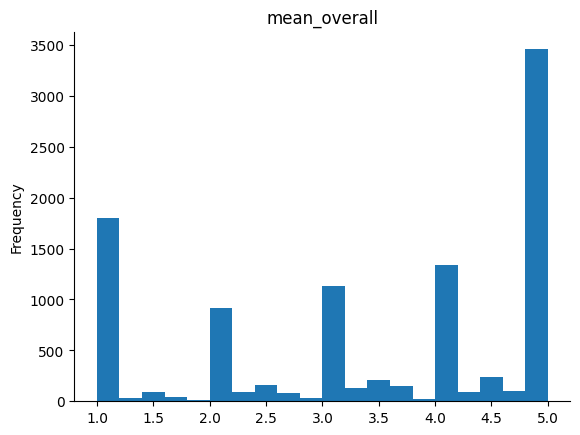

In [53]:
mean_overall['mean_overall'].plot(kind='hist', bins=20, title='mean_overall')
plt.gca().spines[['top', 'right',]].set_visible(False)